In [13]:
# Imports libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, f1_score,
    confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

In [14]:
#  Load Dataset
train_df = pd.read_csv("/kaggle/input/naamii-task-2-dataset/TASK_2/train_set.csv")
test_df = pd.read_csv("/kaggle/input/naamii-task-2-dataset/TASK_2/test_set.csv")
blinded_test_df = pd.read_csv("/kaggle/input/naamii-task-2-dataset/TASK_2/blinded_test_set.csv")

# Preprocessing 
X_train = train_df.drop(columns=["ID", "CLASS"])
y_train = train_df["CLASS"]
X_test = test_df.drop(columns=["ID", "CLASS"])
y_test = test_df["CLASS"]
X_blinded = blinded_test_df.drop(columns=["ID"])

train_ids = train_df["ID"]
test_ids = test_df["ID"]
blinded_ids = blinded_test_df["ID"]

# Handle inf values
for df in [X_train, X_test, X_blinded]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define preprocessing pipeline
numeric_features = X_train.columns.tolist()
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features)
])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_blinded_processed = preprocessor.transform(X_blinded)


In [15]:
# Evaluation Function 
def get_metrics(model, X, y_true):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return {
        "Accuracy": acc,
        "AUROC": auc,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

def save_probabilities_csv(model, X, ids, filename):
    probs = model.predict_proba(X)
    prob_df = pd.DataFrame(probs, columns=["Class_0_Prob", "Class_1_Prob"])
    prob_df.insert(0, "ID", ids.values)
    prob_df.to_csv(filename, index=False)

# Model Training & Evaluation 

results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [17]:
# Logistic Regression 
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train_processed, y_train)
results['Logistic Regression'] = {
    "Train": get_metrics(log_reg, X_train_processed, y_train),
    "Test": get_metrics(log_reg, X_test_processed, y_test)
}

# Random Forest 
rf_grid = {
    "n_estimators": [100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5]
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=cv,
                        scoring='roc_auc', n_jobs=-1)
rf_model.fit(X_train_processed, y_train)
rf_best = rf_model.best_estimator_
results['Random Forest'] = {
    "Train": get_metrics(rf_best, X_train_processed, y_train),
    "Test": get_metrics(rf_best, X_test_processed, y_test)
}

#  XGBoost 
xgb_grid = {
    "n_estimators": [100],
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.05]
}
xgb_model = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                         xgb_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_model.fit(X_train_processed, y_train)
xgb_best = xgb_model.best_estimator_
results['XGBoost'] = {
    "Train": get_metrics(xgb_best, X_train_processed, y_train),
    "Test": get_metrics(xgb_best, X_test_processed, y_test)
}

#  Final Class-Probability CSVs 
save_probabilities_csv(xgb_best, X_train_processed, train_ids, "train_predictions.csv")
save_probabilities_csv(xgb_best, X_test_processed, test_ids, "test_predictions.csv")
save_probabilities_csv(xgb_best, X_blinded_processed, blinded_ids, "blinded_test_predictions.csv")


#  Results Table 
print("\nFinal Evaluation Results (Train & Test Sets):\n")
results_df = pd.DataFrame([
    {
        "Model": model,
        "Dataset": dataset,
        **metrics
    }
    for model, model_results in results.items()
    for dataset, metrics in model_results.items()
])
print(results_df.round(4))


Final Evaluation Results (Train & Test Sets):

                 Model Dataset  Accuracy   AUROC  Sensitivity  Specificity  \
0  Logistic Regression   Train      1.00  1.0000       1.0000       1.0000   
1  Logistic Regression    Test      0.59  0.6466       0.4524       0.6897   
2        Random Forest   Train      1.00  1.0000       1.0000       1.0000   
3        Random Forest    Test      0.63  0.6708       0.3095       0.8621   
4              XGBoost   Train      1.00  1.0000       1.0000       1.0000   
5              XGBoost    Test      0.61  0.6326       0.3571       0.7931   

   F1-score  
0    1.0000  
1    0.4810  
2    1.0000  
3    0.4127  
4    1.0000  
5    0.4348  


In [3]:
#display initial rows

display(train_df.head())
display(test_df.head())
display(blinded_test_df.head())

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238,CLASS
0,ID_1,18281.541667,18432.0,9409.650391,0.514708,0.011300,0.045369,2.803803,0.356658,1.803803,...,382.968383,2214.0,1.0,136.625113,0.061710,0.0,28.154838,4.174959,0.061710,0
1,ID_2,20010.083333,20100.0,8303.049072,0.417707,0.014959,0.080294,2.338398,0.429532,1.338398,...,452.986164,2548.5,1.0,232.564022,0.090548,0.0,27.934229,3.931950,0.090548,1
2,ID_3,27260.125000,27437.0,12189.649414,0.447160,0.011428,0.046402,2.782842,0.359345,1.782842,...,419.781765,3400.0,1.0,233.593529,0.068704,0.0,27.904807,4.085035,0.068704,1
3,ID_4,41938.125000,42138.0,17866.433594,0.426019,0.009908,0.034878,3.060655,0.326727,2.060655,...,439.023968,5424.0,1.0,427.429572,0.078803,0.0,27.870588,4.011726,0.078803,0
4,ID_5,41274.125000,41439.0,14315.041992,0.346828,0.013596,0.065680,2.478506,0.403469,1.478506,...,485.209184,5096.0,1.0,726.731554,0.142608,0.0,28.846909,3.571352,0.142608,0


,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238,CLASS
0,ID_1,15385.458333,15472.5,6357.250488,0.413973,0.017592,0.111930,2.108410,0.478124,1.108410,...,444.535442,1934.5,1.0,170.507074,0.086972,0.0,29.952211,3.963248,0.086972,1
1,ID_2,19539.729167,19651.5,8168.700928,0.417849,0.014973,0.079801,2.326599,0.430171,1.326599,...,450.784676,2480.5,1.0,234.801218,0.094857,0.0,31.625858,3.942665,0.094857,0
2,ID_3,34867.125000,35049.0,14382.916992,0.412507,0.011404,0.046211,2.786669,0.358851,1.786669,...,439.605257,4299.0,1.0,449.882066,0.104648,0.0,28.805248,3.788374,0.104648,0
3,ID_4,46112.083333,46290.0,16512.630859,0.358098,0.012261,0.053411,2.655353,0.376598,1.655353,...,477.467085,5742.0,1.0,706.494949,0.123040,0.0,27.601655,3.675757,0.123040,0
4,ID_5,37229.000000,37383.0,12981.727539,0.348699,0.014201,0.071650,2.407654,0.415342,1.407654,...,488.478334,4754.0,1.0,650.593185,0.136852,0.0,28.207070,3.620278,0.136852,0


,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3229,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238
0,ID_101,13249.250000,13323.0,5322.087891,0.401690,0.019253,0.131701,1.965488,0.508780,0.965488,...,453.349939,453.349939,1646.0,1.0,162.029162,0.098438,0.0,30.580378,3.888605,0.098438
1,ID_102,60593.666667,60804.0,21327.521484,0.351976,0.010976,0.042804,2.858719,0.349807,1.858719,...,492.250478,492.250478,7853.0,1.0,961.759455,0.122470,0.0,26.690038,3.695084,0.122470
2,ID_103,51978.833333,52193.0,19574.339844,0.376583,0.010708,0.040742,2.906154,0.344097,1.906154,...,482.387417,482.387417,6644.0,1.0,763.046057,0.114847,0.0,30.037774,3.804517,0.114847
3,ID_104,47737.416667,47943.0,17247.173828,0.361293,0.011891,0.050236,2.710158,0.368982,1.710158,...,475.620243,475.620243,6017.0,1.0,718.741732,0.119452,0.0,27.964103,3.699860,0.119452
4,ID_105,33029.458333,33261.0,15901.136719,0.481423,0.009294,0.030688,3.194060,0.313081,2.194060,...,417.949466,417.949466,4116.0,1.0,314.568513,0.076426,0.0,31.802140,4.078748,0.076426



Train Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Columns: 3240 entries, ID to CLASS
dtypes: float64(3238), int64(1), object(1)
memory usage: 7.8+ MB
None

Missing Values:
ID              0
Feature_1       0
Feature_2       0
Feature_3       0
Feature_4       0
               ..
Feature_3235    0
Feature_3236    0
Feature_3237    0
Feature_3238    0
CLASS           0
Length: 3240, dtype: int64

Descriptive statistics:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238,CLASS
count,315,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,...,315.000000,315.000000,315.0,315.000000,315.000000,315.0,315.000000,315.000000,315.000000,315.000000
unique,315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36401.611839,36558.978836,13421.797935,0.399783,0.013326,0.066770,2.572654,0.395949,1.572654,...,458.273347,4580.805291,1.0,620.374167,0.112015,0.0,28.510670,3.792381,0.112015,0.393651
std,NaN,23979.228698,24006.711019,5229.346354,0.064272,0.002885,0.034442,0.305500,0.054492,0.305500,...,39.628050,2980.121623,0.0,1254.417871,0.043563,0.0,1.711272,0.257607,0.043563,0.489336
min,NaN,4601.166667,4646.000000,2420.351481,0.137726,0.008904,0.028169,1.684709,0.304269,0.684709,...,309.374029,591.333333,1.0,45.791124,0.058477,0.0,16.430985,1.995746,0.058477,0.000000
25%,NaN,23287.562500,23443.500000,10245.704590,0.357646,0.011459,0.046652,2.403035,0.359990,1.403035,...,432.298489,2881.000000,1.0,245.299821,0.083622,0.0,27.691774,3.655440,0.083622,0.000000
50%,NaN,34818.166667,35028.000000,13894.792969,0.394076,0.012477,0.055314,2.624547,0.381018,1.624547,...,460.598280,4377.000000,1.0,424.561776,0.103960,0.0,28.424340,3.815115,0.103960,0.000000
75%,NaN,45575.708333,45750.000000,16633.839844,0.434799,0.014242,0.072065,2.777867,0.416141,1.777867,...,484.566083,5769.000000,1.0,702.791528,0.131579,0.0,29.450389,3.963320,0.131579,1.000000



Test Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 3240 entries, ID to CLASS
dtypes: float64(3238), int64(1), object(1)
memory usage: 2.5+ MB
None

Missing Values:
ID              0
Feature_1       0
Feature_2       0
Feature_3       0
Feature_4       0
               ..
Feature_3235    0
Feature_3236    0
Feature_3237    0
Feature_3238    0
CLASS           0
Length: 3240, dtype: int64

Descriptive statistics:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238,CLASS
count,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
unique,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36053.786458,36214.821667,13592.064411,0.396674,0.013031,0.063118,2.600435,0.390476,1.600435,...,459.472339,4561.901667,1.0,559.835599,0.110281,0.0,28.416517,3.801596,0.110281,0.420000
std,NaN,15327.976819,15355.686383,4319.053890,0.059999,0.002661,0.029819,0.290887,0.050831,0.290887,...,36.402913,1956.770922,0.0,503.131803,0.038825,0.0,1.528245,0.245532,0.038825,0.496045
min,NaN,6218.729167,6297.000000,3841.149780,0.218619,0.008883,0.028036,1.794599,0.303790,0.794599,...,332.313781,796.500000,1.0,45.581936,0.057231,0.0,22.407271,2.746720,0.057231,0.000000
25%,NaN,25357.187500,25519.000000,10880.779541,0.358070,0.011479,0.046821,2.528735,0.360423,1.528735,...,438.895007,3247.750000,1.0,255.950253,0.084645,0.0,27.434784,3.675486,0.084645,0.000000
50%,NaN,35002.104167,35176.500000,14217.937988,0.389202,0.012330,0.054013,2.645460,0.378006,1.645460,...,466.321559,4418.500000,1.0,482.071018,0.107324,0.0,28.445182,3.798834,0.107324,0.000000
75%,NaN,43567.947917,43737.500000,15871.476562,0.425203,0.013193,0.061849,2.774520,0.395462,1.774520,...,480.090858,5451.500000,1.0,664.924645,0.123209,0.0,29.410854,3.960391,0.123209,1.000000



Blinded Test Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Columns: 3239 entries, ID to Feature_3238
dtypes: float64(3238), object(1)
memory usage: 911.1+ KB
None

Missing Values:
ID              0
Feature_1       0
Feature_2       0
Feature_3       0
Feature_4       0
               ..
Feature_3234    0
Feature_3235    0
Feature_3236    0
Feature_3237    0
Feature_3238    0
Length: 3239, dtype: int64

Descriptive statistics:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_3229,Feature_3230,Feature_3231,Feature_3232,Feature_3233,Feature_3234,Feature_3235,Feature_3236,Feature_3237,Feature_3238
count,36,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.0,36.000000,36.000000,36.0,36.000000,36.000000,36.000000
unique,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36381.127122,36541.277778,13631.158940,0.405920,0.013211,0.065335,2.589071,0.393706,1.589071,...,456.117598,456.117598,4583.398148,1.0,574.627871,0.109175,0.0,29.003962,3.825620,0.109175
std,NaN,18798.136469,18838.271175,5512.018630,0.071102,0.002873,0.031112,0.328434,0.055438,0.328434,...,44.129095,44.129095,2381.690181,0.0,498.355891,0.037869,0.0,1.645398,0.250235,0.037869
min,NaN,6743.222222,6797.000000,3338.486979,0.282432,0.009294,0.030688,1.941702,0.313081,0.941702,...,331.560473,331.560473,765.333333,1.0,52.077214,0.062741,0.0,25.738961,3.208621,0.062741
25%,NaN,24438.947917,24569.000000,10102.937500,0.358557,0.011142,0.044113,2.413214,0.353324,1.413214,...,440.013675,440.013675,3201.750000,1.0,272.506535,0.085810,0.0,27.747591,3.698666,0.085810
50%,NaN,37753.875000,37940.000000,14892.043945,0.405953,0.012502,0.055533,2.621135,0.381517,1.621135,...,455.950536,455.950536,4668.000000,1.0,398.628300,0.101369,0.0,29.213753,3.850503,0.101369
75%,NaN,45658.666667,45823.500000,17086.297363,0.428828,0.014152,0.071170,2.830355,0.414398,1.830355,...,483.804810,483.804810,5774.750000,1.0,754.194726,0.120206,0.0,29.938047,3.993069,0.120206


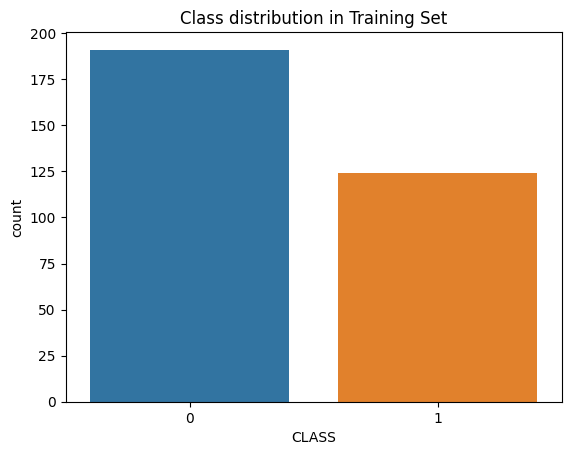

In [4]:
# overview of data types and nulls

def dataset_summary(df, name = "Dataset"):
    print(f"\n{name} Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDescriptive statistics:")
    display(df.describe(include = 'all'))


dataset_summary(train_df, "Train Set")
dataset_summary(test_df, "Test Set")
dataset_summary(blinded_test_df, "Blinded Test Set")

#visualize class distribution 
if 'CLASS' in train_df.columns:
    sns.countplot(data= train_df, x = 'CLASS')
    plt.title("Class distribution in Training Set")
    plt.show()

In [5]:
#import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [6]:
# 1. Drop ID and separate target
X_train = train_df.drop(columns=["ID", "CLASS"])
y_train = train_df["CLASS"]

X_test = test_df.drop(columns=["ID", "CLASS"])
y_test = test_df["CLASS"]

X_blinded = blinded_test_df.drop(columns=["ID"])

# Store IDs
train_ids = train_df["ID"]
test_ids = test_df["ID"]
blinded_ids = blinded_test_df["ID"]

# 2. Handle inf values before preprocessing
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_blinded.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Define numeric preprocessing pipeline
numeric_features = X_train.columns.tolist()
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features)
])

# 4. Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_blinded_processed = preprocessor.transform(X_blinded)

In [7]:
# import libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix


In [8]:
#utility to calculate all required metrics

def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"\n{dataset_name} Evaluation for {model.__class__.__name__}")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"AUROC       : {auc:.4f}")
    print(f"Sensitivity : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    

# Prepare stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [9]:
#logistic regression

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train_processed, y_train)
evaluate_model(log_reg, X_test_processed, y_test)


Test Evaluation for LogisticRegression
Accuracy    : 0.5900
AUROC       : 0.6466
Sensitivity : 0.4524
Specificity : 0.6897
F1 Score    : 0.4810


In [10]:
# random forest

rf_grid = {
    "n_estimators": [100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5]
}

rf_model = GridSearchCV(RandomForestClassifier(random_state = 42), rf_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1 )
rf_model.fit(X_train_processed, y_train)
evaluate_model(rf_model.best_estimator_, X_test_processed, y_test)



Test Evaluation for RandomForestClassifier
Accuracy    : 0.6300
AUROC       : 0.6708
Sensitivity : 0.3095
Specificity : 0.8621
F1 Score    : 0.4127


In [11]:
# XGBoost (with tuning)

xgb_grid = {
    "n_estimators": [100],
    "max_depth": [3,5],
    "learning_rate": [0.1, 0.05]
}

xgb_model = GridSearchCV(XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'), xgb_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)
xgb_model.fit(X_train_processed, y_train)
evaluate_model(xgb_model.best_estimator_, X_test_processed, y_test)


Test Evaluation for XGBClassifier
Accuracy    : 0.6100
AUROC       : 0.6326
Sensitivity : 0.3571
Specificity : 0.7931
F1 Score    : 0.4348


In [12]:
# ======================= Final Class-Probability CSVs ==========================
save_probabilities_csv(xgb_best, X_train_processed, train_ids, "train_predictions.csv")
save_probabilities_csv(xgb_best, X_test_processed, test_ids, "test_predictions.csv")
save_probabilities_csv(xgb_best, X_blinded_processed, blinded_ids, "blinded_test_predictions.csv")

# ======================= Results Table ==========================
print("\nFinal Evaluation Results (Train & Test Sets):\n")
results_df = pd.DataFrame([
    {
        "Model": model,
        "Dataset": dataset,
        **metrics
    }
    for model, model_results in results.items()
    for dataset, metrics in model_results.items()
])
print(results_df.round(4))

NameError: name 'save_probabilities_csv' is not defined